In [27]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
from collections import OrderedDict, Counter
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
import os
import sys
sys.path.insert(0, '../../src')
from utils import ProcessData
from starlette.config import Config

import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto

from googletrans import Translator
import googlemaps

from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_absolute_error
import xgboost as xgb
from hyperopt.pyll.base import scope 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import smogn

translator = Translator()
config = Config("../../../../../.env")
pw = config("HASEKO_DATA_PW", cast=str)
# google_api_key = config("HASEKO_GOOGLE_API_KEY", cast=str)
# gmaps = googlemaps.Client(key=google_api_key)

%matplotlib inline

In [28]:
def get_boundaries(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, column):
    lower_bound, upper_bound = get_boundaries(df, column)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def reverse_transform(X, tr):
    for name, transfo in enumerate(list(tr[0])):
        if transfo =='Squared':
            X = np.squeeze(np.square(X))
        elif transfo == 'Log':
            X = np.squeeze(np.expm1(X))
        else:
            X = np.squeeze(X)
    return X

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        x, y = data.mean(), data.std()
        data = (data-x)/y
    elif method == 'minmax':
        # Min-max normalization
        x, y = data.min(), data.max()
        data = (data-x)/(y-x)
    return data, (x.values[0],y.values[0])

def unskew_data(data):
    def process_data(data, idx):
        d = {}
        for i in data.columns:
            method = idx.loc[i,0]
            if method == 'Log':
                d[i] = np.log1p(data[i])
            elif method == 'Squared':
                d[i] = np.sqrt(data[i])
            else:
                d[i] = data[i]
        data_pr = pd.DataFrame(data=d, columns = data.columns)
        data_pr = data_pr.fillna(data_pr.mean())
        return data_pr
    
    data = data.astype(float)

    data_log = pd.DataFrame(np.log1p(data), columns= data.columns)
    data_square = pd.DataFrame(np.sqrt(data), columns= data.columns)

    data_skewness = pd.concat([data.skew(), data_log.skew(), data_square.skew()], axis=1)
    data_skewness.columns = ['Raw','Log','Squared']
    data_min = data_skewness.abs().idxmin(axis=1).to_frame()
    data_unskewed = process_data(data, data_min)
    
    return data_unskewed, data_min

def score_regression(params):
    reg = xgb.XGBRegressor(**params).fit(**fit_params)
    return {'loss': mean_absolute_error(reg.predict(X_test), y_test), 'status': STATUS_OK, 'model': reg}

def optimize_regression(trials, space, tries):
    return fmin(fn=score_regression, space=space, algo=tpe.suggest, max_evals=tries, trials=trials, show_progressbar=True)

def format_params(space, best):
    best['objective'] = obj.get(best['objective'])
    best['max_depth'] += 1
    best['min_child_weight'] += 1
    for k,v in space.items():
        if k not in best.keys():
            best[k] = v
    return best

# New training data

In [29]:
area = {'1100': 'Saitama',
        '1200': 'Chiba',
        '1301': 'Central Tokyo',
        '1302': 'Western Tokyo',
        '1303': 'Eastern Tokyo',
        '1304': 'Tokyo city',
        '1400': 'Kanagawa'}

new_dict = ['年齢\nage','合算後年収.1\nAnnual income after the sum .1','合算後年収\nAnnual income after the sum', '家族数\nFamily number',
            '家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)', '面積\narea','LP名\nLP name',
            '最新住所\nLatest address']

In [44]:
data_dir = '../../haseko_v1_data_analysis/data/コピーデータ240215_4回目.xls'
unlocked_file = io.BytesIO()

excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
df = pd.read_excel(unlocked_file)

df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]
df['物件価格(千円)\nProperty price (1,000 yen)'] /= 10

# Select relevant columns
df = df[new_dict]
# Remove outlier
df = remove_outliers(df, '面積\narea')
# Remove possible pair loan
col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','最新住所\nLatest address']
dup = df[df.duplicated(subset=col, keep=False)]
df = df.loc[[i for i in df.index if i not in dup.index],:]

print(df.shape)
df.head()

(3740, 9)


,年齢\nage,合算後年収.1\nAnnual income after the sum .1,合算後年収\nAnnual income after the sum,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,最新住所\nLatest address
2,36,8,～800万円,2,DINKS,3298.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
3,48,4,～400万円,1,独身,3378.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
4,42,4,～500万円,1,独身,3598.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
5,29,4,～500万円,3,独身,2588.0,30.72,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
6,51,4,～400万円,1,独身,3448.0,35.73,今回追加したデータ,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前


In [45]:
dup.head()

,年齢\nage,合算後年収.1\nAnnual income after the sum .1,合算後年収\nAnnual income after the sum,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,最新住所\nLatest address
0,35,10,～1000万円,3,ファミリー,4800.0,65.01,マンション中心のLPの案件,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
1,34,10,～1000万円,3,ファミリー,4800.0,65.01,マンション中心のLPの案件,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
10,35,9,～1000万円,2,DINKS,7032.0,64.45,マンション中心のLPの案件,さいたま市浦和区 仲町 １－９－１０ Brillia浦和仲町
11,32,9,～1000万円,2,DINKS,7032.0,64.45,マンション中心のLPの案件,さいたま市浦和区 仲町 １－９－１０ Brillia浦和仲町
22,31,7,～700万円,2,DINKS,4058.0,65.94,今回追加したデータ,稲城市 大丸 ２２１６－１ ミオカステーロ南多摩


In [46]:
df.describe()

,年齢\nage,合算後年収.1\nAnnual income after the sum .1,家族数\nFamily number,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea
count,3740.000000,3740.000000,3740.000000,3740.000000,3740.000000
mean,42.136364,8.551337,2.155615,4871.678155,55.317642
std,8.139471,5.762277,1.087682,1897.727288,15.856137
min,22.000000,1.000000,0.000000,2000.000000,25.510000
25%,36.000000,6.000000,1.000000,3698.000000,39.800000
50%,41.000000,7.000000,2.000000,4428.000000,61.300000
75%,47.000000,10.000000,3.000000,5534.250000,67.622500
max,72.000000,198.000000,7.000000,22280.000000,93.060000


# Previous training data

In [47]:
pws_dict = {'age':'年齢\nage',
            'income':'合算後年収.1\nAnnual income after the sum .1',
            'family_members':'家族数\nFamily number',
            'mf_family_type_str':'家族F\nFamily F',
            'price':'物件価格(千円)\nProperty price (1,000 yen)',
            'width':'面積\narea',
            'name':'LP名\nLP name',
            'pref_code':'pref_code',
            'pref_name':'pref_name',
            'city_code':'city_code',
            'city_name':'city_name',
            'area_code':'area_code',
            'area_name':'area_name',
            'search_area_code':'search_area_code',
            'search_area_name':'search_area_name',
            'lon':'lon',
            'lat':'lat'}

In [48]:
base_params = '../../src/params'
base_data = '../../haseko_v0/data/mansionfit_2020-12-02.csv'

data = ProcessData()
params_ml, _, area_data = data.load_json_file(base_params)
pws, _, _ = data.create_user_buildings_df(base_data, area_data)
pws = pws.dropna(axis=0)
pws['family_members'] = pws['family_members'].astype(int)
pws['income'] /= 1000000
pws['price'] /= 10000
pws = pws[pws_dict.keys()]
pws.columns = pws_dict.values()
print(pws.shape)
col = ['家族数\nFamily number','家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)','面積\narea','LP名\nLP name','pref_code','pref_name','city_code','city_name','area_code','area_name','search_area_code','search_area_name','lon','lat']
pws = pws.drop_duplicates(subset=col, keep=False, inplace=False)

print(pws.shape)
pws.head(1)

(5487, 17)
(4884, 17)


,年齢\nage,合算後年収.1\nAnnual income after the sum .1,家族数\nFamily number,家族F\nFamily F,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,LP名\nLP name,pref_code,pref_name,city_code,city_name,area_code,area_name,search_area_code,search_area_name,lon,lat
0,53.0,15.0,5,パートナーと子供,5589.91,70.56,ザ・ガーデンズ東京王子,13,東京都,13117,北区,1303,東京東部,1303,東京23区東エリア,139.726858,35.763803


In [49]:
pws.describe()

,年齢\nage,合算後年収.1\nAnnual income after the sum .1,家族数\nFamily number,"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,pref_code,city_code,area_code,search_area_code,lon,lat
count,4884.000000,4884.000000,4884.000000,4884.000000,4884.000000,4884.000000,4884.00000,4884.000000,4884.000000,4884.000000,4884.000000
mean,38.637183,8.119795,3.356675,4403.501235,72.393886,12.833333,12996.65131,1284.473382,1287.825143,139.703630,35.670284
std,8.612569,4.381547,0.649623,1128.634505,6.049969,1.002591,995.40469,100.460176,101.026800,0.215004,0.149971
min,20.000000,0.360000,1.000000,2290.000000,31.410000,11.000000,11102.00000,1100.000000,1101.000000,139.155772,35.256225
25%,33.000000,5.680000,3.000000,3578.000000,68.820000,12.000000,12207.00000,1200.000000,1208.000000,139.472653,35.568784
50%,37.000000,7.300000,3.000000,4218.000000,71.400000,13.000000,13119.00000,1303.000000,1303.000000,139.726858,35.683640
75%,43.000000,9.525000,4.000000,4988.000000,75.000000,14.000000,14110.00000,1400.000000,1403.000000,139.872458,35.769954
max,79.000000,100.000000,7.000000,23100.000000,140.190000,14.000000,14216.00000,1400.000000,1499.000000,140.122849,35.985632


# Data aggregation & training

In [50]:
obj = {0:'reg:squarederror', 1:'reg:pseudohubererror',2:'reg:absoluteerror'}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 50))),
         'min_child_weight': scope.int(hp.choice('min_child_weight', np.arange(1, 50))),
         'subsample': hp.quniform('subsample', 0.1, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.1, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'seed': 0}

r_index: 100%|########################################################################| 35/35 [00:00<00:00, 781.91it/s]

  0%|                                                                          | 0/250 [00:00<?, ?trial/s, best loss=?]

100%|██████████████████████████████████████████████| 250/250 [00:53<00:00,  4.69trial/s, best loss: 0.7173395727492224]


r_index: 100%|########################################################################| 87/87 [00:00<00:00, 838.53it/s]

  0%|                                                                          | 0/250 [00:00<?, ?trial/s, best loss=?]

100%|██████████████████████████████████████████████| 250/250 [00:41<00:00,  5.99trial/s, best loss: 0.6891473290250156]


r_index: 100%|########################################################################| 84/84 [00:00<00:00, 813.94it/s]

  0%|                                                                          | 0/250 [00:00<?, ?trial/s, best loss=?]

100%|██████████████████████████████████████████████| 250/250 [00:44<00:00,  5.57trial/s, best loss: 0.6542431389621036]


r_index: 100%|########################################################################| 48/48 [00:00<00:00, 783.91it/s]


100%|██████████████████████████████████████████████| 250/250 [01:18<00:00,  3.17trial/s, best loss: 0.6567513312994595]


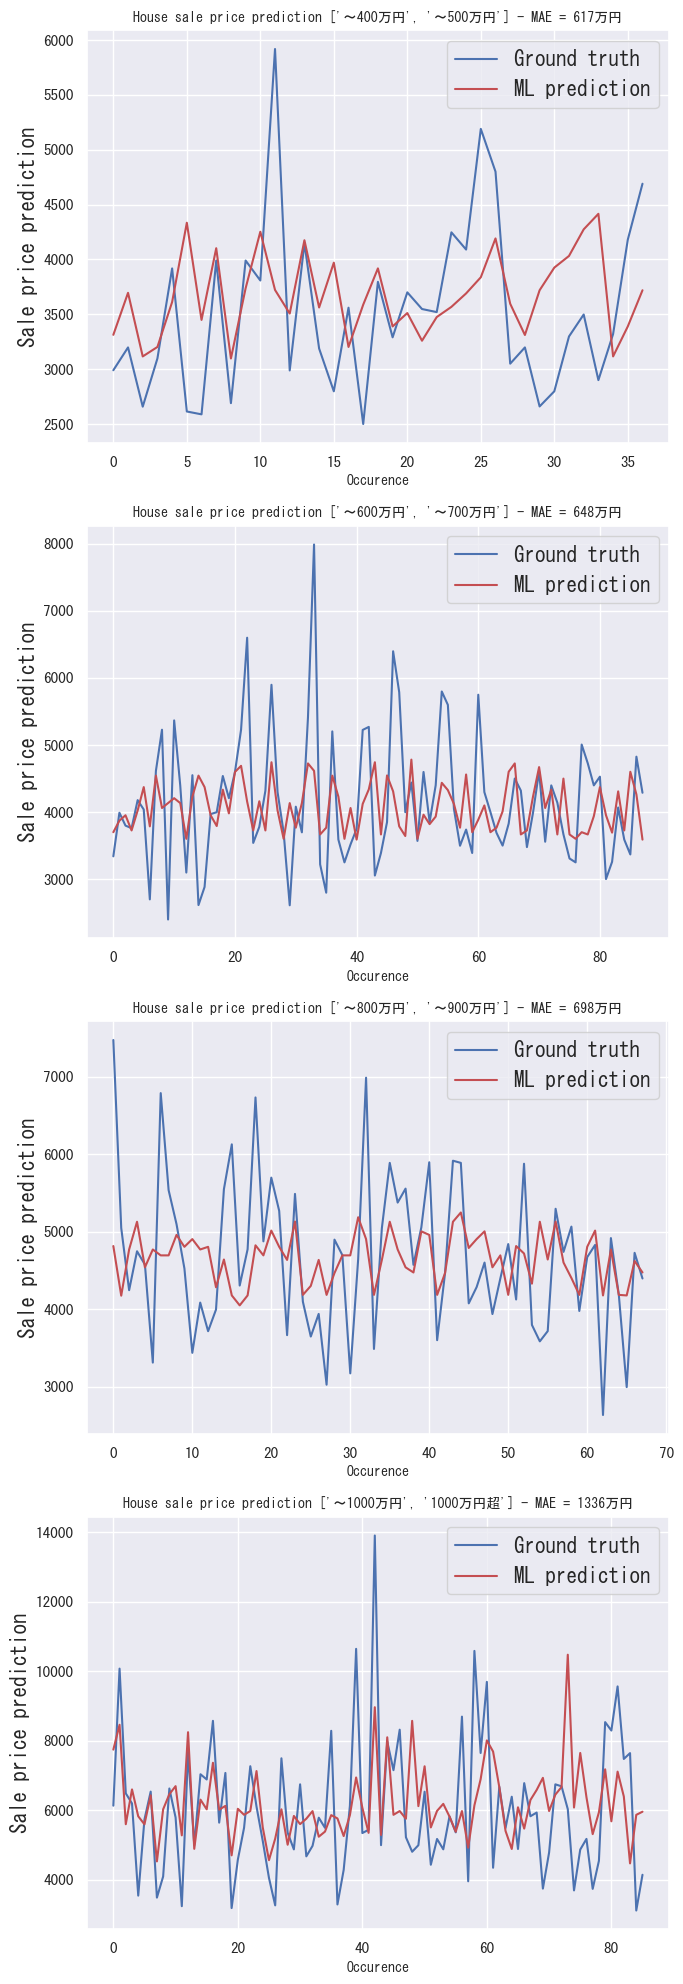

In [62]:
match_family_type = {'DINKS':'パートナー','ファミリー':'パートナーと子供','自分ひとり':'独身'}
data = pd.concat([df, pws],axis=0).rename(columns={'物件価格(千円)\nProperty price (1,000 yen)':'物件価格(万円)\nProperty price (10,000 yen)'})
data['家族F\nFamily F'] = [match_family_type[i] if i in match_family_type.keys() else i for i in data['家族F\nFamily F']]
data['salary@65'] = [(65 - age) * salary * 0.02 for age, salary in zip(data['年齢\nage'], data['合算後年収.1\nAnnual income after the sum .1'])]
data['kids_expenses'] = [max(0, (i-2)*100000*12) for i in data['家族数\nFamily number']]
data['estimated_savings'] = [(age - 25) * salary * 0.06 if status == '独身' else (age - 25) * salary * 0.03 if status == 'パートナー' else (age - 25) * salary * 0.01 for status, age, salary in zip(data['家族F\nFamily F'], data['年齢\nage'], data['合算後年収.1\nAnnual income after the sum .1'])]

range_salary = [['～400万円','～500万円'],['～600万円','～700万円'],['～800万円','～900万円'],['～1000万円','1000万円超']]

sns.set(font_scale=1.0, font="MS Gothic")
plt.figure(figsize=(7,20))

for idx_plot, range_ in enumerate(range_salary):
    data_train = data.copy()
    data_in = data_train[data_train['合算後年収\nAnnual income after the sum'].isin(range_)]
    data_in = data_in.reset_index(drop=True)

    col = ['年齢\nage','家族数\nFamily number','家族F\nFamily F','合算後年収\nAnnual income after the sum','物件価格(万円)\nProperty price (10,000 yen)',]
    data_in = data_in.dropna(subset=col)
    
    norm_method = 'mean'
    continuous_col = ['家族数\nFamily number', '年齢\nage', 'salary@65']
    categorical_col = ['家族F\nFamily F', '合算後年収\nAnnual income after the sum']

    data_continuous, transform_input = unskew_data(data_in[continuous_col])
    data_continuous, (x_in, y_in) = normalization(data_continuous, norm_method)

    encoder = OneHotEncoder(dtype=np.int64, sparse=True)
    data_categorical = pd.DataFrame(encoder.fit_transform(data_in[categorical_col]).toarray(),
                                    columns = [i for i in encoder.get_feature_names_out()],
                                    index = data_in.index)

    dataframe = pd.concat([data_continuous, data_categorical], axis=1)

    target_col = ['物件価格(万円)\nProperty price (10,000 yen)']
    target = data_in[target_col]

    target, transform_output = unskew_data(target)
    target, (x_out, y_out) = normalization(target, norm_method)

    _, bin_edges = np.histogram(target, density=True)
    bin_indices = np.digitize(np.squeeze(target.to_numpy()), bin_edges)
    valid_bins = np.where(np.bincount(bin_indices) >= 2)[0]
    valid_data_indices = np.isin(bin_indices, valid_bins)

    filtered_dataframe = dataframe[valid_data_indices]
    filtered_target = target[valid_data_indices]
    filtered_bin_indices = bin_indices[valid_data_indices]

    X_train, X, y_train, y = train_test_split(filtered_dataframe, filtered_target, test_size=0.15, random_state=5, shuffle=True, stratify=filtered_bin_indices)

    df_smoter = pd.concat((X_train,y_train), axis=1).reset_index()
    df_smoter = df_smoter.dropna()
    smoter = smogn.smoter(data = df_smoter, y = "物件価格(万円)\nProperty price (10,000 yen)")
    X_train = smoter[list(filtered_dataframe.columns)]
    y_train = smoter[['物件価格(万円)\nProperty price (10,000 yen)']]

    _, bin_edges = np.histogram(y, density=True)
    bin_indices = np.digitize(np.squeeze(y), bin_edges)
    valid_bins = np.where(np.bincount(bin_indices) >= 2)[0]
    valid_data_indices = np.isin(bin_indices, valid_bins)

    filtered_dataframe = X[valid_data_indices]
    filtered_target = y[valid_data_indices]
    filtered_bin_indices = bin_indices[valid_data_indices]

    X_val, X_test, y_val, y_test = train_test_split(filtered_dataframe, filtered_target, test_size=0.5, random_state=5, shuffle=True, stratify=filtered_bin_indices)

    fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 50,
              'eval_metric': ['rmse','mae'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}
    
    trials = Trials()
    best = optimize_regression(trials, space, 250)
    params = format_params(space, best)
    xgb_reg = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

    pred = np.expand_dims(xgb_reg.predict(X_test), axis=1)

    if norm_method == 'mean': # Mean normalization
        pred = pred * y_out + x_out 
        gt = y_test * y_out + x_out
    elif norm_method == 'minmax': # Min Max normalization
        pred = pred * (y_out - x_out) + x_out
        gt = y_test * (y_out - x_out) + x_out

    pred = reverse_transform(pred, transform_output)
    gt = reverse_transform(gt, transform_output)
    
    d = {'Ground truth': gt, 'Pred': pred}
    res_pred = pd.DataFrame(data=d).reset_index()
    mae = mean_absolute_error(gt, pred)

    # Plotting results
    plt.subplot(4,1,idx_plot+1)
    plt.plot(res_pred[['Ground truth']],'b-', label='Ground truth')
    plt.plot(res_pred[['Pred']],'r-', label='ML prediction')
    plt.xlabel('Occurence', fontsize=10)
    plt.ylabel('Sale price prediction', fontsize=15)
    plt.title(f'House sale price prediction {str(range_)} - MAE = {int(mae)}万円', fontsize=10)
    plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [23]:
# price_range = [price > pred[idx] - 1.0 * mae and price <  pred[idx] + 1.0*mae for idx, price in enumerate(gt)]
# print(sum(price_range)/len(price_range))

0.6612903225806451


In [24]:
# excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
# excel_file.load_key(password = pw)
# excel_file.decrypt(unlocked_file)
# borrowed = pd.read_excel(unlocked_file)

# borrowed.columns = [unicodedata.normalize('NFKC', s) for s in borrowed.columns]
# borrowed.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in borrowed.columns]
# borrowed = borrowed[['借入金額(百万円単位)\nBorrowed amount (million yen units)']]

# borrowed['借入金額(百万円単位)\nBorrowed amount (million yen units)'] *= 100
# borrowed = borrowed.rename(columns={'借入金額(百万円単位)\nBorrowed amount (million yen units)':'借入金額(万円)\nBorrowed amount'})

In [26]:
# false_indices = [index for index, value in enumerate(price_range) if value == False]
# error_price_index = X_test.index[false_indices]
# verification_price = data.loc[error_price_index,:]
# verification_price['GT'] = gt.to_numpy()[false_indices]
# verification_price['prediction'] = pred[false_indices]
# verification_price = verification_price.sort_values(by='GT', ascending=False)
# verification_price = pd.merge(verification_price, borrowed, left_index=True, right_index=True, how='left')

# verification_price.head(15)